# Evaluation
This notebook will walk you step by step through the process of using the detection results files included in the zip folders of each pre-trained model.

In [15]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from itertools import cycle
from PIL import Image
import numpy as np
import pandas as pd
import pickle
import os
import copy

np.random.seed(1)

In [16]:
EPSILON = 1e-5
# Load GTSDB validation images
CLASSES = ['prohibitory','mandatory','danger']
#Path to the German Traffic Sign Detection Benchmark dataset
DATASET_PATH = 'archive (1)/ts/ts'
full_set = ['%05d.jpg' % x for x in range(900)]
valid_set = full_set[600:900]

In [17]:
category_index = {1: {'id': 1, 'name': 'prohibitory'},
 2: {'id': 2, 'name': 'mandatory'},
 3: {'id': 3, 'name': 'danger'}}
categories = [{'id': 1, 'name': 'prohibitory'},
 {'id': 2, 'name': 'mandatory'},
 {'id': 3, 'name': 'danger'}]

## Load detection results

In [18]:
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
# MODEL_NAME = 'faster_rcnn_resnet_101'
# MODEL_NAME = 'faster_rcnn_resnet50'
# MODEL_NAME = 'faster_rcnn_inception_v2'
# MODEL_NAME = 'rfcn_resnet101'
# MODEL_NAME = 'ssd_inception_v2'
# MODEL_NAME = 'ssd_mobilenet_v1'
MODEL_NAME = 'yolo_v2'

In [23]:
MODEL_PATH =  MODEL_NAME
with open(os.path.join(MODEL_PATH, 'detections_output_result.pkl'), 'rb') as pickle_file:
    detections = pickle.load(pickle_file)

## Helper code

In [24]:
def filter_val_detections(detections):
    fdetects = []
    for d in detections:
        if d['file'] in valid_set:
            fdetects.append(d)
    return fdetects

In [25]:
def filter_detections_by_width(detections, min_w, max_w):
    fdetects = []
    n_gt_bboxes = 0
    for d in detections:
        d_aux = copy.deepcopy(d)
        j = 0
        for i, bbox in enumerate(d['gt_bboxes']):
            w = bbox[2] - bbox[0]
            if w < min_w or w >= max_w:
                d_aux['gt_bboxes'].pop(i - j)
                d_aux['gt_classes'].pop(i - j)
                try:
                    d_aux['pred_bboxes'].pop(i - j)
                    d_aux['pred_classes'].pop(i - j)
                    d_aux['confidences'].pop(i - j)
                except IndexError:
                    print('Pred bbox num {} of image {} was not removed'.format(i,d_aux['file']))
                j += 1 
        n_gt_bboxes += len(d_aux['gt_bboxes'])
        fdetects.append(d_aux)
    print(n_gt_bboxes)
    return fdetects

In [26]:
def get_detection_by_filename(detections, filename):
    for detection in detections:
        if detection['file'] == filename:
            return detection

In [27]:
def plot_rectangle(bbox,ax,class_name,edgecolor,confidence=None):
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    left = xmin
    right = xmax
    top = ymin
    bot = ymax
    ax.add_patch(
        plt.Rectangle((left, top),
                      right-left,
                      bot-top, fill=False,
                      edgecolor=edgecolor, linewidth=2)
        )
    label = '{:s}:'.format(class_name)
    label += ' {0:.2f}%'.format(confidence)
    label_pos_y = ((bot - top) / 2) + top + 3.5
    label_pos_x = right+10
    if class_name == 'danger':
        label_pos_x = left
        label_pos_y = top - 9
    elif class_name == 'prohibitory':
        label_pos_x = left - 30
        label_pos_y = bot + 15
    ax.text(label_pos_x, label_pos_y,label,
            bbox=dict(facecolor=edgecolor, edgecolor=edgecolor, alpha=1),
            fontsize=11)

In [28]:
CLASSES_COLOR = ['DarkOrange','Aqua','Chartreuse']
def plot_dets(detection, model_name):
    fig, ax = plt.subplots(figsize=(20, 20))
    image = np.array(Image.open(detection['file_path']))
    image = np.squeeze(image)
    imWidth = image.shape[1]
    imHeight = image.shape[0]
    for j in range(len(detection['pred_bboxes'])):
        pred_class = detection['pred_classes'][j]
        bbox = detection['pred_bboxes'][j]
        confidence = detection['confidences'][j] * 100
        plot_rectangle(bbox,ax,category_index[pred_class]['name'],CLASSES_COLOR[pred_class-1], confidence)
    plt.axis('off')
    ax.imshow(image, aspect='equal')

In [29]:
def intersection(bbgt, bb):
    # determine the (x, y)-coordinates of the intersection rectangle
    ixmin = max(bbgt[0], bb[0])
    iymin = max(bbgt[1], bb[1])
    ixmax = min(bbgt[2], bb[2])
    iymax = min(bbgt[3], bb[3])
    
    # compute the area of intersection rectangle
    iw = max(ixmax - ixmin, 0)
    ih = max(iymax - iymin, 0)
    intersArea = iw * ih
    
    return intersArea

In [30]:
def union(bbgt, bb, intersArea):
    # compute the area of both the prediction and ground-truth rectangles
    boxgtArea = (bbgt[2] - bbgt[0]) * (bbgt[3] - bbgt[1])
    boxArea = (bb[2] - bb[0]) * (bb[3] - bb[1])
    unionArea = boxgtArea + boxArea - intersArea
    return unionArea

In [31]:
# Returns the intersection over union of two rectangles, a and b, where each is an array [x,y,w,h]
def compute_iou(bbgt, bb):
    overlaps = np.zeros(len(bbgt))
    for i,gtBbox in enumerate(bbgt):
        inters = float(intersection(gtBbox, bb))
        uni = union(gtBbox, bb, inters)
        iou = inters/uni
        overlaps[i] = iou
    ioumax = np.max(overlaps)
    jmax = np.argmax(overlaps)
    return ioumax, jmax

In [32]:
def naive_ap_calculation(rec,prec):
    """
    Take sum of P(k) * \Delta recall(k)
    """
    deltaRecall = []
    rec = np.insert(rec,0,0)
    for i in range(1,rec.shape[0]):
        deltaRecall.append( rec[i] - rec[i-1] ) # find differences
    deltaRecall = np.array(deltaRecall)
    ap = np.dot( deltaRecall,prec)
    return ap

In [33]:
def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        # http://host.robots.ox.ac.uk/pascal/VOC/pubs/everingham10.pdf (page 313)
        
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation (from VOC 2010 challenge)
        # http://host.robots.ox.ac.uk/pascal/VOC/voc2012/devkit_doc.pdf (page 12)
        
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [34]:
def match_gts_and_compute_prec_recall_ap(cls,detections,iouthresh=0.5):
    """
    INPUTS:
    -BB: predicted bounding boxes
    -BBGT: predicted bounding boxes, BBGT = R['bbox'].astype(float)
    OUTPUTS:
    -rec: recall
    -prec: precision
    -ap: average precision
    A bounding box reported by an algorithm is considered
    correct if its area intersection over union with a ground 
    truth bounding box is beyond 50%. If a lot of closely overlapping 
    bounding boxes hitting on a same ground truth, only one of
    them is counted as correct, and all the others are treated as false alarms
    """
    print('IoU threshold set to: {:.2f}'.format(iouthresh))
    GT_OBJECTS = {}
    BB = []
    BB_im_ids = []
    BB_confidences = []
    n_gt_bboxes = 0
    
    for dId,d in enumerate(detections):
        BBGT = []
        for i in range(len(d['gt_bboxes'])):
            if d['gt_classes'][i] == cls:
                BBGT.append(d['gt_bboxes'][i])
                n_gt_bboxes += 1
        GT_OBJECTS[d['file']] = {
            'bboxes' : np.asarray(BBGT),
            'detected?' : [False] * len(BBGT)
        }
        for i in range(len(d['pred_bboxes'])):
            if d['pred_classes'][i] == cls:
                BB.append(d['pred_bboxes'][i])
                BB_im_ids.append(d['file'])
                BB_confidences.append(d['confidences'][i])
      
    if n_gt_bboxes == 0:
        return None,None,None
    
    BB = np.asarray(BB)
    BB_confidences = np.asarray(BB_confidences)
    
    # sort by confidence
    if len(BB) > 0:
        sorted_ind = np.argsort(-BB_confidences)
        sorted_scores = np.sort(-BB_confidences)
        BB = BB[sorted_ind, :]
        BB_im_ids = [BB_im_ids[x] for x in sorted_ind]            
    
    num_detections = len(BB_im_ids)
    tp = np.zeros(num_detections)
    fp = np.zeros(num_detections)
    avg_overlap = []
    
    for d in range(num_detections):
        gt_info = GT_OBJECTS[BB_im_ids[d]]
        bb = BB[d, :].astype(float)
        BBGT = gt_info['bboxes'].astype(float)
        ioumax = -np.inf
        
        if BBGT.size > 0:
            # compute intersection over union
            ioumax, jmax = compute_iou(BBGT,bb)
        if ioumax > iouthresh:
            if not gt_info['detected?'][jmax]:
                tp[d] = 1. # true positive
                gt_info['detected?'][jmax] = 1
                avg_overlap.append(ioumax)
            else:
                fp[d] = 1. # false positive (multiple detection)
        else:
            fp[d] = 1. # false positive
        
    avg_overlap = np.array(avg_overlap) if len(avg_overlap) > 0 else np.array([0])
    
    # compute precision recall
    fp = np.cumsum(fp) if len(fp) > 0 else np.array([0])
    tp = np.cumsum(tp) if len(tp) > 0 else np.array([0])
    
    fn = n_gt_bboxes - tp[-1]
    
    rec = tp / np.maximum(tp + fn, np.finfo(np.float64).eps)
    # avoid divide by zero in case the first detection matches a difficult ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    
    ap = voc_ap(rec, prec)
    
    print("TP: {}".format(tp[-1]))
    print("FP: {}".format(fp[-1]))
    print("FN: {}".format(fn))
    class_name = category_index[cls]['name']
    print('Avg. overlap for {} = {:.4f}'.format(class_name, np.mean(avg_overlap)))
    
    print('Precision for {} = {:.4f}'.format(class_name, prec[-1]))
    print('Recall for {} = {:.4f}'.format(class_name, rec[-1]))
    
    return rec, prec, ap

In [35]:
def plot_precision_recall(prec, recall, ap):
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [recall[-1]]))
    mpre = np.concatenate(([prec[0]], prec, [0.]))
    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(mrec, mpre, lw=2, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: AP={0:0.2f}'.format(ap))
    plt.legend(loc="lower left")
    plt.show()

In [36]:
def plot_full_precision_recall(data):
    fig, ax = plt.subplots(figsize=(6, 4))
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    for d in data:
        recall = d['recall']
        prec = d['precision']
        ap = d['ap']
        cls = d['class']
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], recall, [recall[-1]]))
        mpre = np.concatenate(([prec[0]], prec, [0.]))
        ax.plot(mrec, mpre, next(linecycler), label='{} (AP = {:.2f}%)'.format(cls,ap*100))
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.draw()
    plt.tight_layout()
    plt.savefig('gtsdb_pre_rec_curves.pdf', format='pdf')
    plt.show()
    plt.clf()

In [37]:
def compute_mean_average_precision(detections):
    """
    INPUTS:
    -detections: python list of objects with fields: class_given_obj, confidences, bboxes
    OUTPUTS:
    -mAP: float
    For each class, we compute average precision (AP)
    This score corresponds to the area under the precision-recall curve.
    The mean of these numbers is the mAP.
    """
    
    results = []
    plot_data = []

#     plotDets(detections)
    aps = []
    
    for category in categories:
        class_name = category['name']
        rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh=0.5)
        
        if rec is None:
            continue
        results.append({'class' : class_name, 'precision' : prec[-1], 'recall' : rec[-1], 'ap' : ap})
        plot_data.append({'class' : class_name, 'precision' : prec, 'recall' : rec, 'ap' : ap})
        if ap is not None:
            aps += [ap]
            print('AP for {} = {:.4f}'.format(class_name, ap))
        plot_precision_recall(prec, rec, ap)
    print('Mean AP = {:.4f}'.format(np.mean(aps)))
    print('~~~~~~~~')
    print('Results:')
    mAP = np.mean(aps)
    df = pd.DataFrame.from_records(results, columns=('class', 'precision', 'recall', 'ap'))
    print(df)
    plot_full_precision_recall(plot_data)
    return mAP

In [38]:
def compute_mean_average_precision_COCO2016(detections):
    """
    INPUTS:
    -detections: python list of objects with fields: class_given_obj, confidences, bboxes
    OUTPUTS:
    -mAP: float
    For each class, we compute average precision (AP)
    This score corresponds to the area under the precision-recall curve.
    The mean of these numbers is the mAP.
    """

#     plotDets(detections)
    aps_class = []
    for category in categories:
        aps_iou = []
        for iouthresh in np.arange(.5, 1, .05):
            rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh)
            if ap is not None:
                aps_iou += [ap]
                print('AP for {} and IoU threshold {:.2f} = {:.4f}'.format(category['name'], iouthresh, ap))
            plot_precision_recall(prec, rec, ap)
        aps_class += [np.mean(aps_iou)] 
        print('Mean AP for {} = {:.4f}'.format(category['name'],np.mean(aps_iou)))
        
    print('Mean AP = {:.4f}'.format(np.mean(aps_class)))
    print('~~~~~~~~')
    print('Results:')
    for ap in aps_class:
        print('{:.3f}'.format(ap))
    print('{:.3f}'.format(np.mean(aps_class)))
    mAP = np.mean(aps_class)
    return mAP

## Filter detections

In [39]:
# Filter detections that belong to validation images
detections = filter_val_detections(detections)

In [40]:
# (0,32) (32,46) (46,1000)
detections_small = filter_detections_by_width(detections, 0, 32)
detections_medium = filter_detections_by_width(detections, 32, 46)
detections_large = filter_detections_by_width(detections, 46, 1000)

Pred bbox num 0 of image 00626.jpg was not removed
Pred bbox num 1 of image 00626.jpg was not removed
Pred bbox num 0 of image 00638.jpg was not removed
Pred bbox num 0 of image 00639.jpg was not removed
Pred bbox num 0 of image 00778.jpg was not removed
Pred bbox num 0 of image 00783.jpg was not removed
Pred bbox num 1 of image 00867.jpg was not removed
Pred bbox num 0 of image 00888.jpg was not removed
89
Pred bbox num 0 of image 00639.jpg was not removed
Pred bbox num 0 of image 00642.jpg was not removed
Pred bbox num 0 of image 00650.jpg was not removed
Pred bbox num 0 of image 00655.jpg was not removed
Pred bbox num 1 of image 00665.jpg was not removed
Pred bbox num 1 of image 00683.jpg was not removed
Pred bbox num 0 of image 00717.jpg was not removed
Pred bbox num 2 of image 00723.jpg was not removed
Pred bbox num 2 of image 00760.jpg was not removed
Pred bbox num 3 of image 00760.jpg was not removed
Pred bbox num 0 of image 00772.jpg was not removed
Pred bbox num 1 of image 007

In [41]:
print(detections[0])

{'pred_classes': [1, 2], 'pred_bboxes': [(823, 461, 843, 482), (386, 507, 432, 550)], 'gt_bboxes': [(387, 505, 434, 554), (821, 464, 845, 488)], 'file_path': '/media/arcos/Shared/Datasets/GermanTSDataset/Detection/00624.jpg', 'gt_classes': [2, 1], 'file': '00624.jpg', 'confidences': [0.67770845, 0.6568578]}


## Eval VOC Pascal 2010+

IoU threshold set to: 0.50
TP: 144.0
FP: 12.0
FN: 17.0
Avg. overlap for prohibitory = 0.7396
Precision for prohibitory = 0.9231
Recall for prohibitory = 0.8944
AP for prohibitory = 0.8873


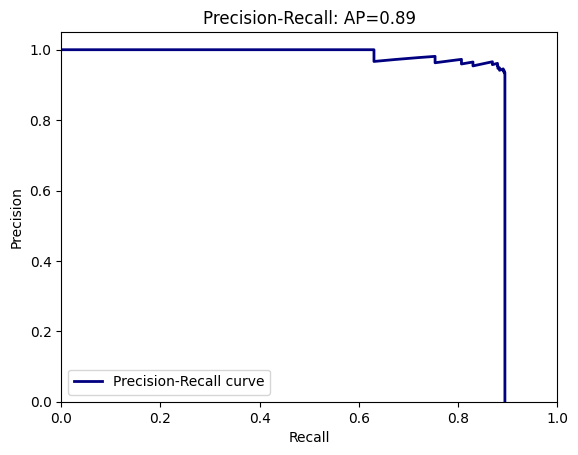

IoU threshold set to: 0.50
TP: 34.0
FP: 9.0
FN: 15.0
Avg. overlap for mandatory = 0.7466
Precision for mandatory = 0.7907
Recall for mandatory = 0.6939
AP for mandatory = 0.6570


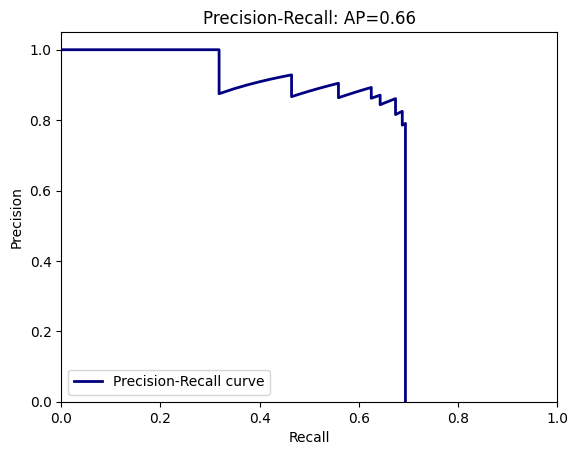

IoU threshold set to: 0.50
TP: 52.0
FP: 3.0
FN: 11.0
Avg. overlap for danger = 0.7582
Precision for danger = 0.9455
Recall for danger = 0.8254
AP for danger = 0.8206


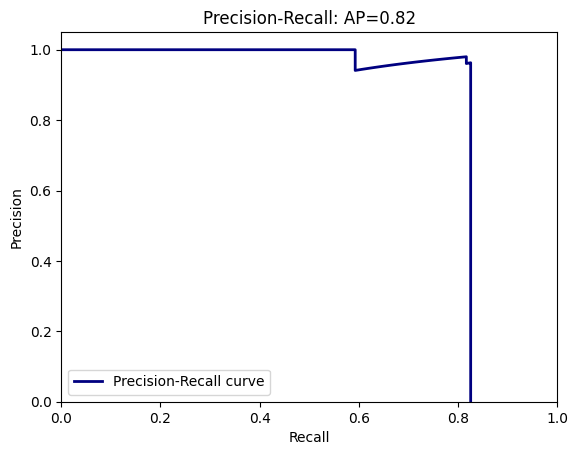

Mean AP = 0.7883
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.923077  0.894410  0.887276
1    mandatory   0.790698  0.693878  0.657018
2       danger   0.945455  0.825397  0.820592


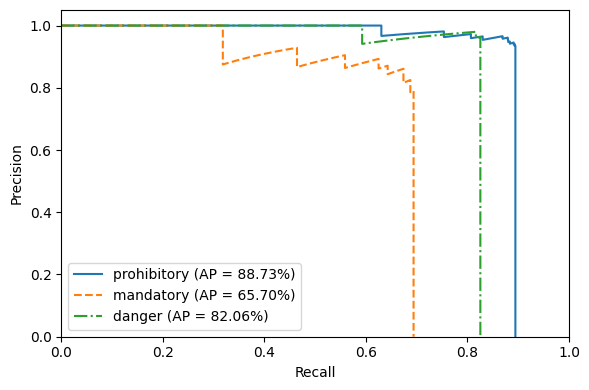

----- Small detections -----
IoU threshold set to: 0.50
TP: 40.0
FP: 10.0
FN: 17.0
Avg. overlap for prohibitory = 0.6969
Precision for prohibitory = 0.8000
Recall for prohibitory = 0.7018
AP for prohibitory = 0.6653


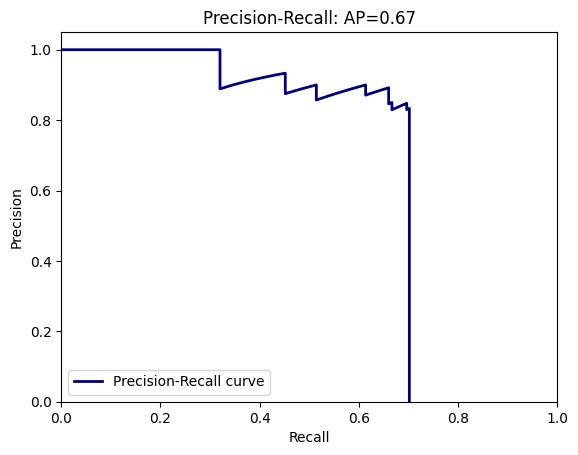

IoU threshold set to: 0.50
TP: 11.0
FP: 11.0
FN: 11.0
Avg. overlap for mandatory = 0.7591
Precision for mandatory = 0.5000
Recall for mandatory = 0.5000
AP for mandatory = 0.3419


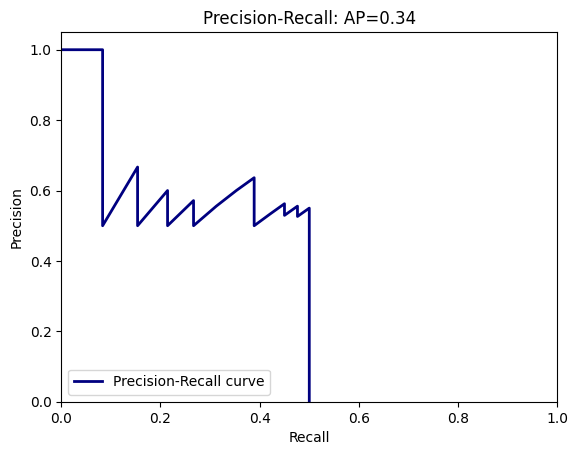

IoU threshold set to: 0.50
TP: 3.0
FP: 3.0
FN: 7.0
Avg. overlap for danger = 0.6337
Precision for danger = 0.5000
Recall for danger = 0.3000
AP for danger = 0.2806


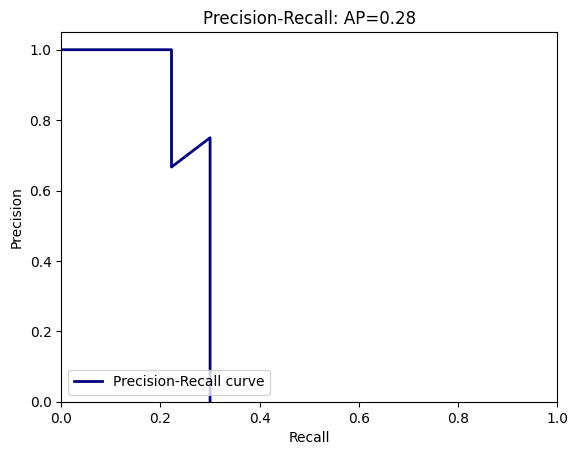

Mean AP = 0.4293
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory        0.8  0.701754  0.665349
1    mandatory        0.5  0.500000  0.341935
2       danger        0.5  0.300000  0.280556


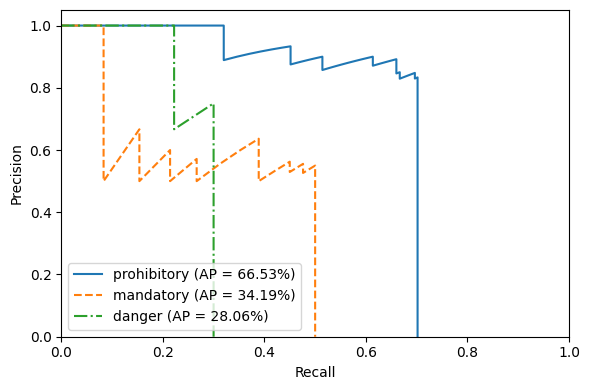

----- Medium detections -----
IoU threshold set to: 0.50
TP: 56.0
FP: 8.0
FN: 8.0
Avg. overlap for prohibitory = 0.7374
Precision for prohibitory = 0.8750
Recall for prohibitory = 0.8750
AP for prohibitory = 0.8354


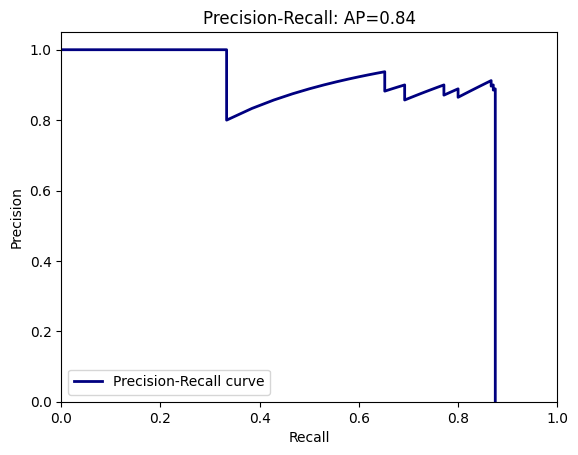

IoU threshold set to: 0.50
TP: 11.0
FP: 8.0
FN: 3.0
Avg. overlap for mandatory = 0.7392
Precision for mandatory = 0.5789
Recall for mandatory = 0.7857
AP for mandatory = 0.6891


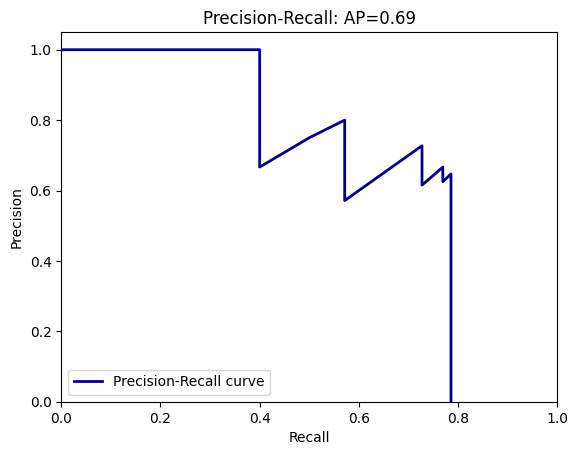

IoU threshold set to: 0.50
TP: 13.0
FP: 4.0
FN: 2.0
Avg. overlap for danger = 0.7264
Precision for danger = 0.7647
Recall for danger = 0.8667
AP for danger = 0.8452


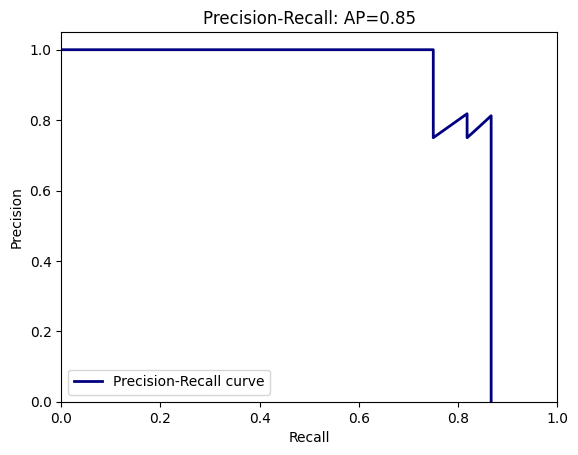

Mean AP = 0.7899
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.875000  0.875000  0.835379
1    mandatory   0.578947  0.785714  0.689122
2       danger   0.764706  0.866667  0.845179


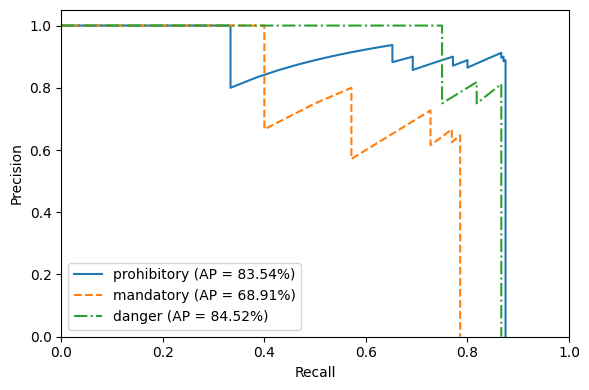

----- Large detections -----
IoU threshold set to: 0.50
TP: 37.0
FP: 11.0
FN: 3.0
Avg. overlap for prohibitory = 0.7955
Precision for prohibitory = 0.7708
Recall for prohibitory = 0.9250
AP for prohibitory = 0.8105


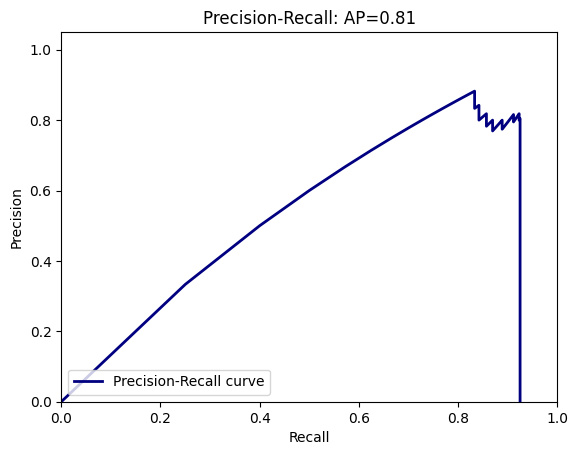

IoU threshold set to: 0.50
TP: 8.0
FP: 8.0
FN: 5.0
Avg. overlap for mandatory = 0.7185
Precision for mandatory = 0.5000
Recall for mandatory = 0.6154
AP for mandatory = 0.5385


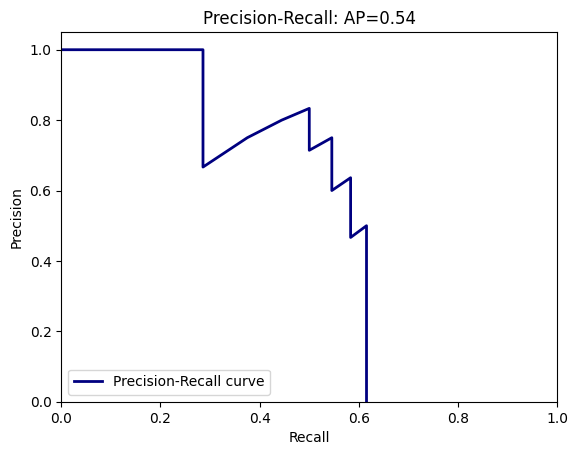

IoU threshold set to: 0.50
TP: 35.0
FP: 1.0
FN: 3.0
Avg. overlap for danger = 0.7754
Precision for danger = 0.9722
Recall for danger = 0.9211
AP for danger = 0.9211


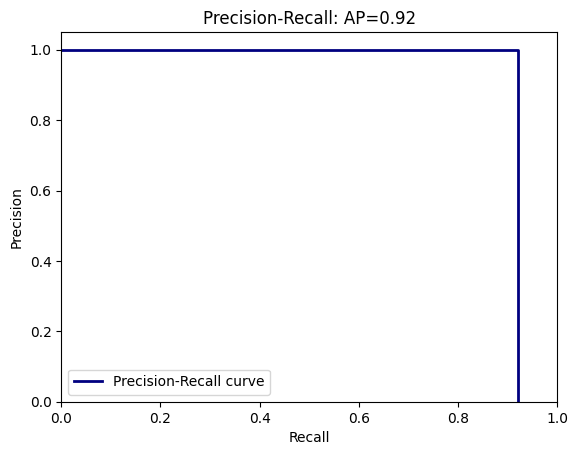

Mean AP = 0.7567
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.770833  0.925000  0.810477
1    mandatory   0.500000  0.615385  0.538507
2       danger   0.972222  0.921053  0.921053


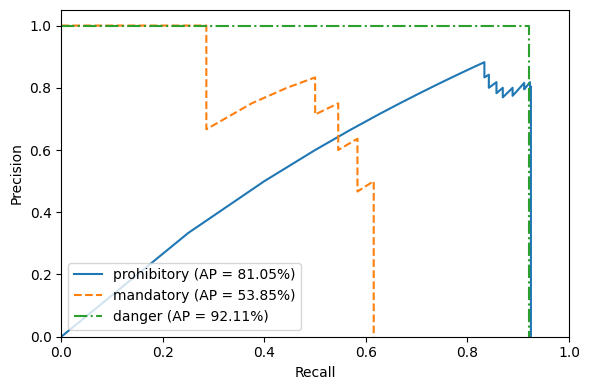

0.7566789825911343

<Figure size 640x480 with 0 Axes>

In [42]:
compute_mean_average_precision(detections)
print("----- Small detections -----")
compute_mean_average_precision(detections_small)
print("----- Medium detections -----")
compute_mean_average_precision(detections_medium)
print("----- Large detections -----")
compute_mean_average_precision(detections_large)

## Eval Microsoft COCO 2016

IoU threshold set to: 0.50
TP: 144.0
FP: 12.0
FN: 17.0
Avg. overlap for prohibitory = 0.7396
Precision for prohibitory = 0.9231
Recall for prohibitory = 0.8944
AP for prohibitory and IoU threshold 0.50 = 0.8873


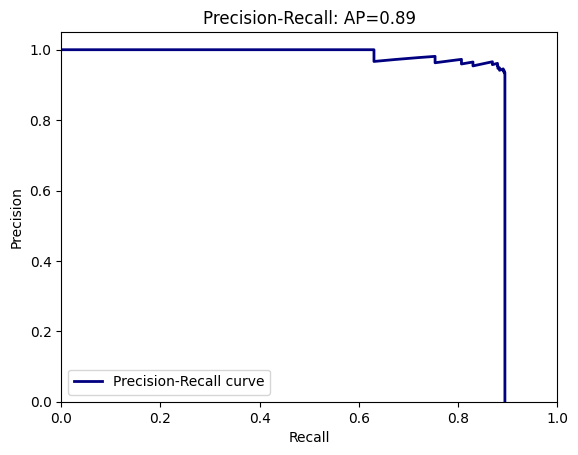

IoU threshold set to: 0.55
TP: 136.0
FP: 20.0
FN: 25.0
Avg. overlap for prohibitory = 0.7519
Precision for prohibitory = 0.8718
Recall for prohibitory = 0.8447
AP for prohibitory and IoU threshold 0.55 = 0.7807


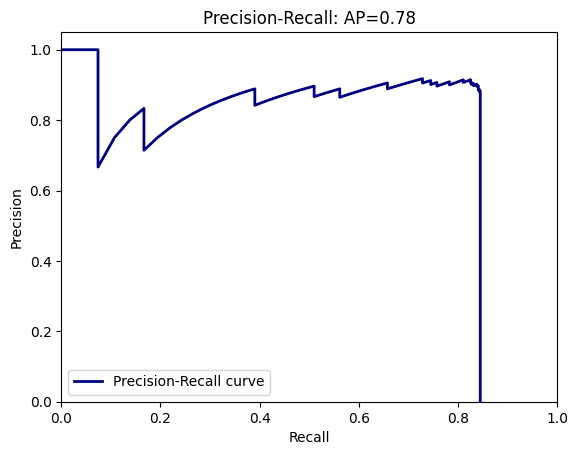

IoU threshold set to: 0.60
TP: 127.0
FP: 29.0
FN: 34.0
Avg. overlap for prohibitory = 0.7641
Precision for prohibitory = 0.8141
Recall for prohibitory = 0.7888
AP for prohibitory and IoU threshold 0.60 = 0.6929


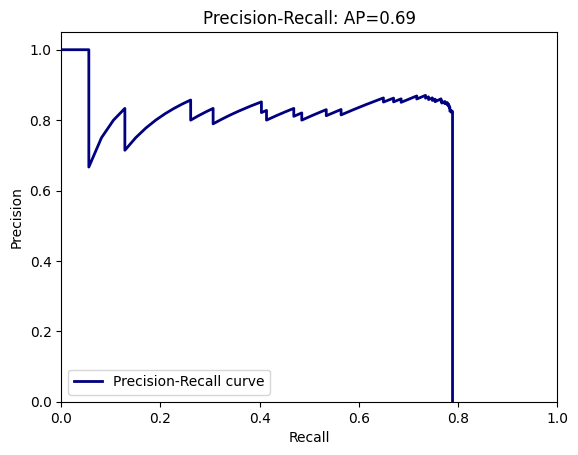

IoU threshold set to: 0.65
TP: 111.0
FP: 45.0
FN: 50.0
Avg. overlap for prohibitory = 0.7843
Precision for prohibitory = 0.7115
Recall for prohibitory = 0.6894
AP for prohibitory and IoU threshold 0.65 = 0.5536


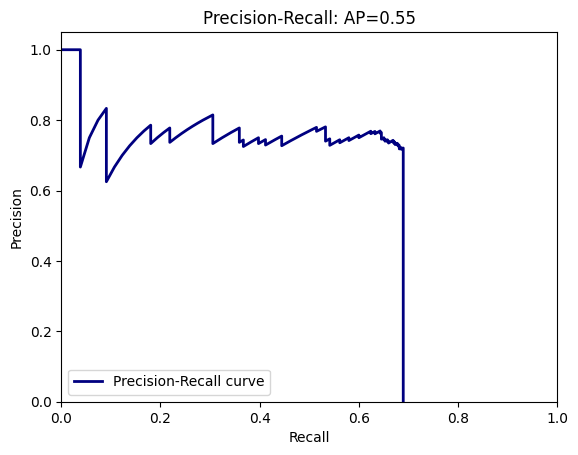

IoU threshold set to: 0.70
TP: 90.0
FP: 66.0
FN: 71.0
Avg. overlap for prohibitory = 0.8090
Precision for prohibitory = 0.5769
Recall for prohibitory = 0.5590
AP for prohibitory and IoU threshold 0.70 = 0.3765


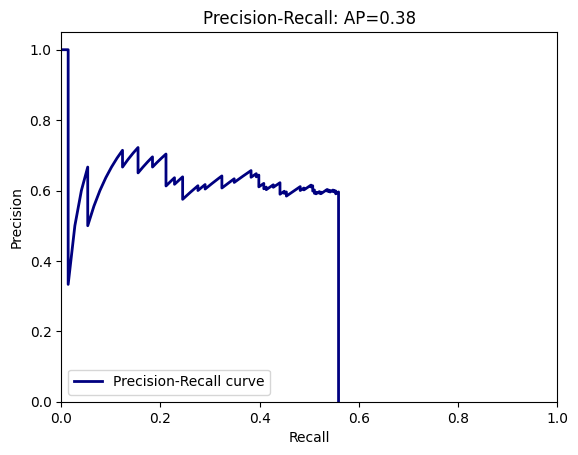

IoU threshold set to: 0.75
TP: 73.0
FP: 83.0
FN: 88.0
Avg. overlap for prohibitory = 0.8299
Precision for prohibitory = 0.4679
Recall for prohibitory = 0.4534
AP for prohibitory and IoU threshold 0.75 = 0.2552


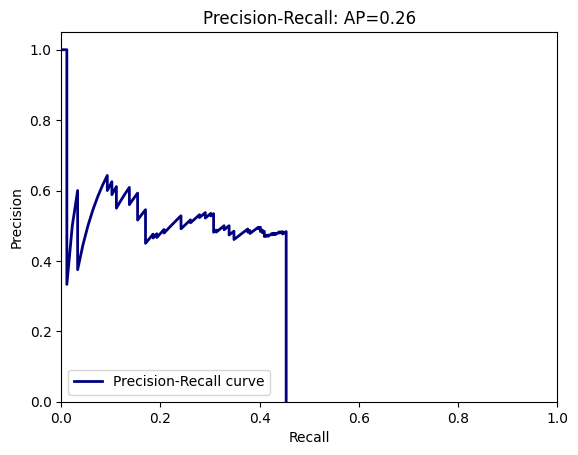

IoU threshold set to: 0.80
TP: 51.0
FP: 105.0
FN: 110.0
Avg. overlap for prohibitory = 0.8549
Precision for prohibitory = 0.3269
Recall for prohibitory = 0.3168
AP for prohibitory and IoU threshold 0.80 = 0.1270


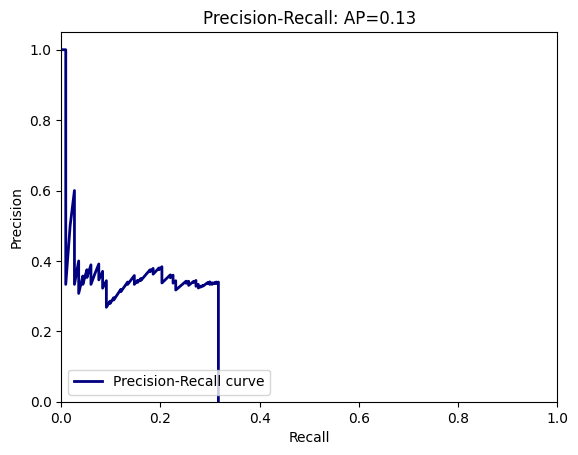

IoU threshold set to: 0.85
TP: 25.0
FP: 131.0
FN: 136.0
Avg. overlap for prohibitory = 0.8914
Precision for prohibitory = 0.1603
Recall for prohibitory = 0.1553
AP for prohibitory and IoU threshold 0.85 = 0.0296


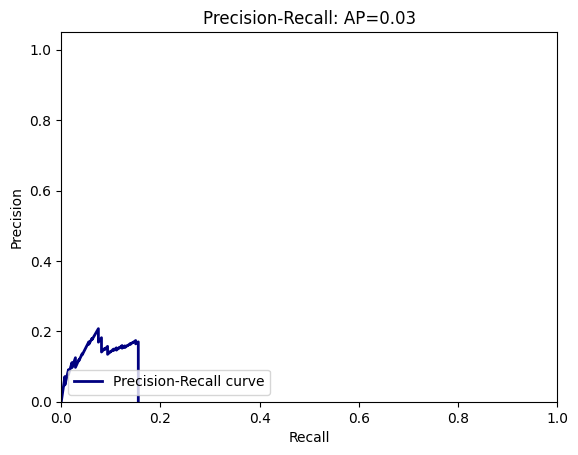

IoU threshold set to: 0.90
TP: 9.0
FP: 147.0
FN: 152.0
Avg. overlap for prohibitory = 0.9280
Precision for prohibitory = 0.0577
Recall for prohibitory = 0.0559
AP for prohibitory and IoU threshold 0.90 = 0.0071


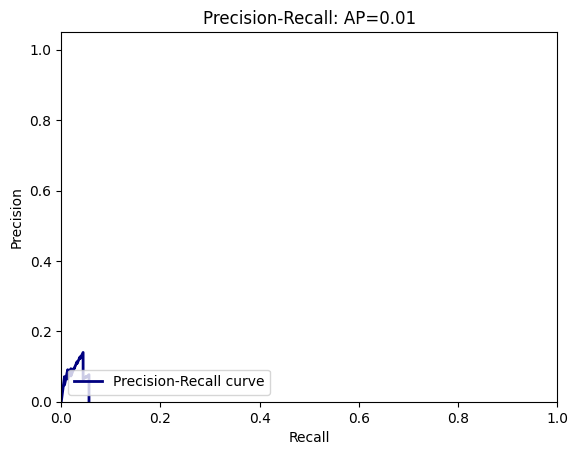

IoU threshold set to: 0.95
TP: 1.0
FP: 155.0
FN: 160.0
Avg. overlap for prohibitory = 0.9787
Precision for prohibitory = 0.0064
Recall for prohibitory = 0.0062
AP for prohibitory and IoU threshold 0.95 = 0.0001


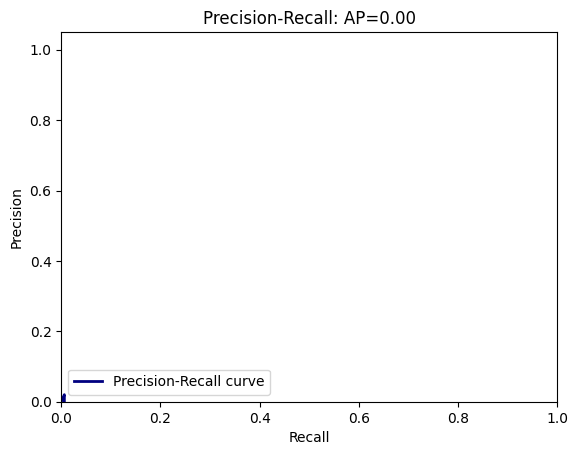

Mean AP for prohibitory = 0.3710
IoU threshold set to: 0.50
TP: 34.0
FP: 9.0
FN: 15.0
Avg. overlap for mandatory = 0.7466
Precision for mandatory = 0.7907
Recall for mandatory = 0.6939
AP for mandatory and IoU threshold 0.50 = 0.6570


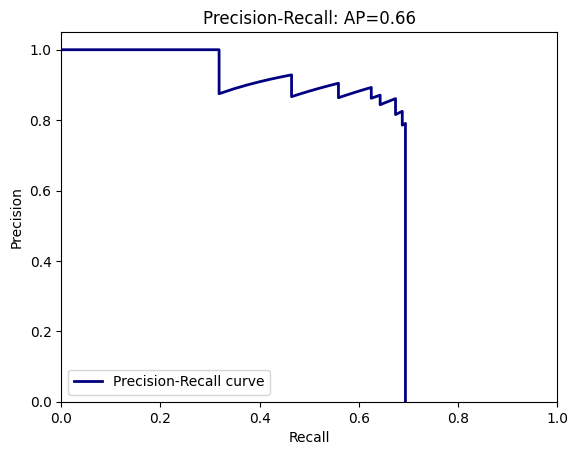

IoU threshold set to: 0.55
TP: 34.0
FP: 9.0
FN: 15.0
Avg. overlap for mandatory = 0.7466
Precision for mandatory = 0.7907
Recall for mandatory = 0.6939
AP for mandatory and IoU threshold 0.55 = 0.6570


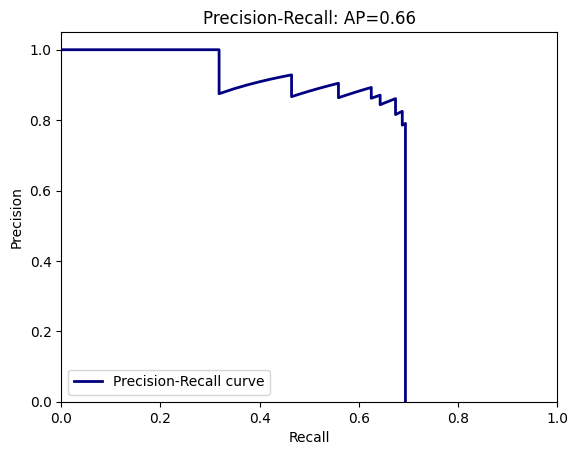

IoU threshold set to: 0.60
TP: 31.0
FP: 12.0
FN: 18.0
Avg. overlap for mandatory = 0.7623
Precision for mandatory = 0.7209
Recall for mandatory = 0.6327
AP for mandatory and IoU threshold 0.60 = 0.5853


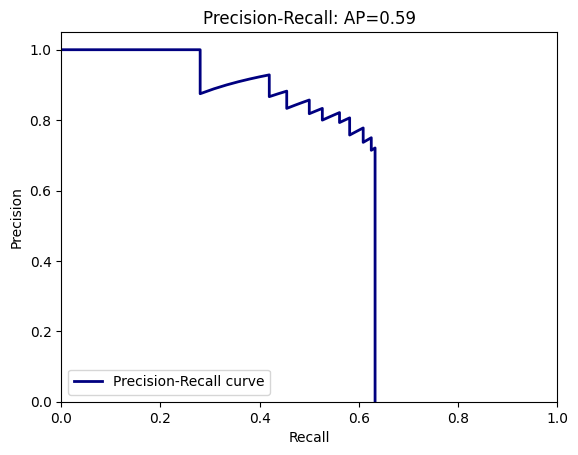

IoU threshold set to: 0.65
TP: 29.0
FP: 14.0
FN: 20.0
Avg. overlap for mandatory = 0.7732
Precision for mandatory = 0.6744
Recall for mandatory = 0.5918
AP for mandatory and IoU threshold 0.65 = 0.5088


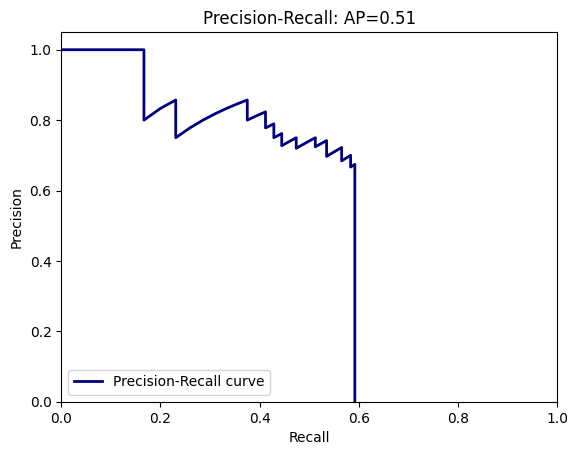

IoU threshold set to: 0.70
TP: 23.0
FP: 20.0
FN: 26.0
Avg. overlap for mandatory = 0.7964
Precision for mandatory = 0.5349
Recall for mandatory = 0.4694
AP for mandatory and IoU threshold 0.70 = 0.3928


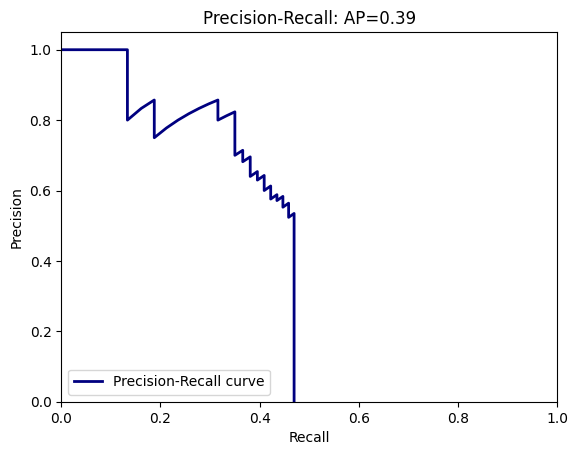

IoU threshold set to: 0.75
TP: 17.0
FP: 26.0
FN: 32.0
Avg. overlap for mandatory = 0.8225
Precision for mandatory = 0.3953
Recall for mandatory = 0.3469
AP for mandatory and IoU threshold 0.75 = 0.2484


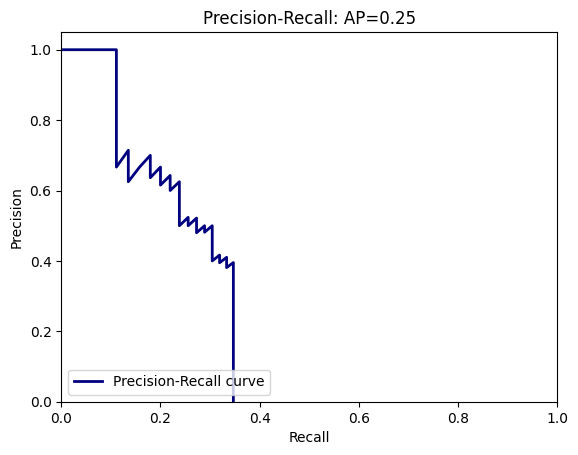

IoU threshold set to: 0.80
TP: 12.0
FP: 31.0
FN: 37.0
Avg. overlap for mandatory = 0.8457
Precision for mandatory = 0.2791
Recall for mandatory = 0.2449
AP for mandatory and IoU threshold 0.80 = 0.1447


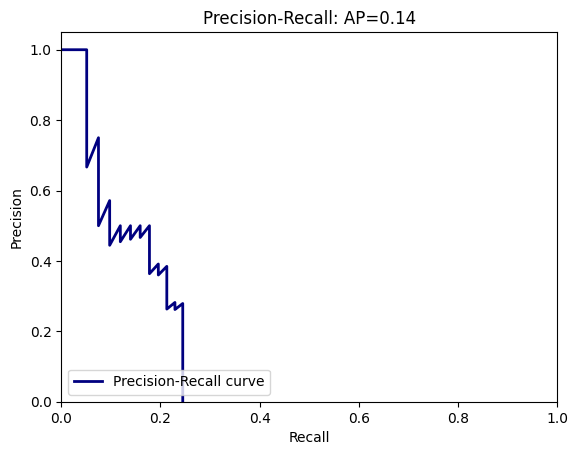

IoU threshold set to: 0.85
TP: 4.0
FP: 39.0
FN: 45.0
Avg. overlap for mandatory = 0.8934
Precision for mandatory = 0.0930
Recall for mandatory = 0.0816
AP for mandatory and IoU threshold 0.85 = 0.0099


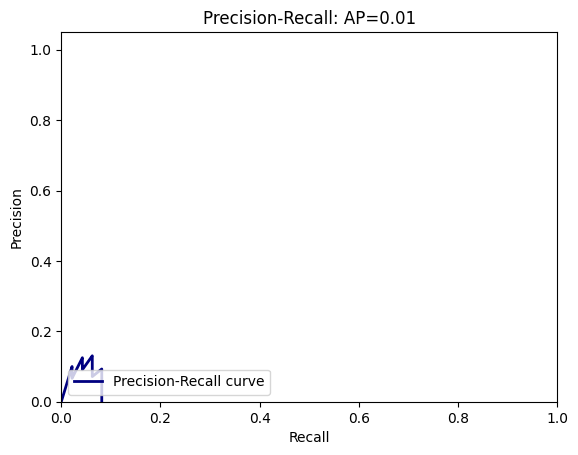

IoU threshold set to: 0.90
TP: 2.0
FP: 41.0
FN: 47.0
Avg. overlap for mandatory = 0.9105
Precision for mandatory = 0.0465
Recall for mandatory = 0.0408
AP for mandatory and IoU threshold 0.90 = 0.0035


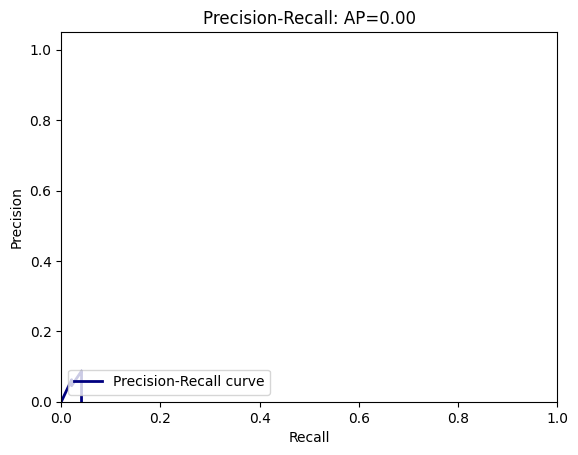

IoU threshold set to: 0.95
TP: 0.0
FP: 43.0
FN: 49.0
Avg. overlap for mandatory = 0.0000
Precision for mandatory = 0.0000
Recall for mandatory = 0.0000
AP for mandatory and IoU threshold 0.95 = 0.0000


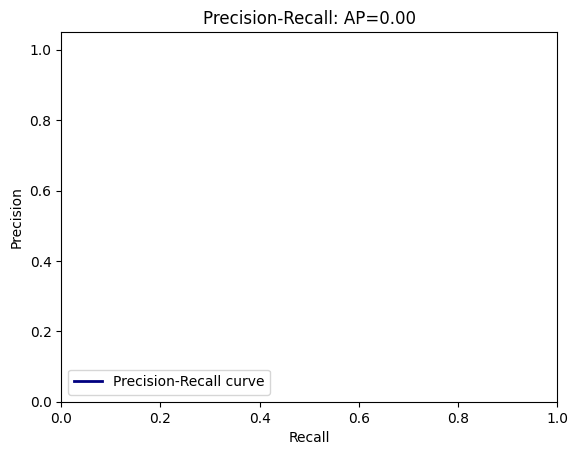

Mean AP for mandatory = 0.3208
IoU threshold set to: 0.50
TP: 52.0
FP: 3.0
FN: 11.0
Avg. overlap for danger = 0.7582
Precision for danger = 0.9455
Recall for danger = 0.8254
AP for danger and IoU threshold 0.50 = 0.8206


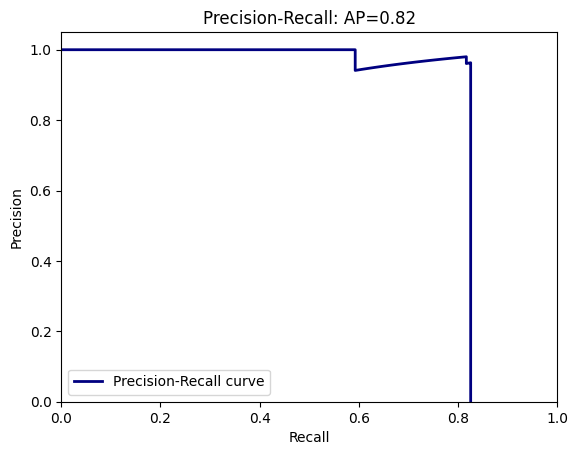

IoU threshold set to: 0.55
TP: 50.0
FP: 5.0
FN: 13.0
Avg. overlap for danger = 0.7676
Precision for danger = 0.9091
Recall for danger = 0.7937
AP for danger and IoU threshold 0.55 = 0.7850


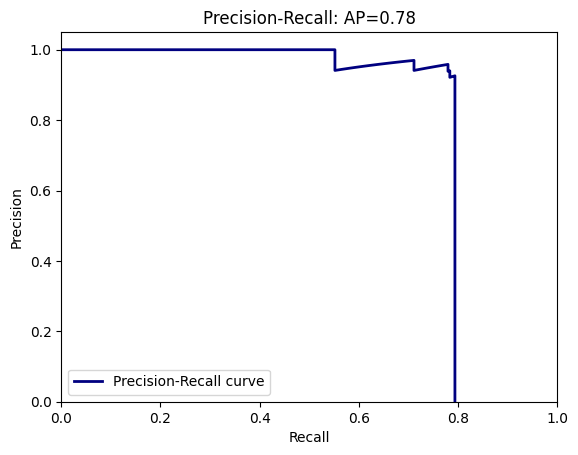

IoU threshold set to: 0.60
TP: 48.0
FP: 7.0
FN: 15.0
Avg. overlap for danger = 0.7758
Precision for danger = 0.8727
Recall for danger = 0.7619
AP for danger and IoU threshold 0.60 = 0.7123


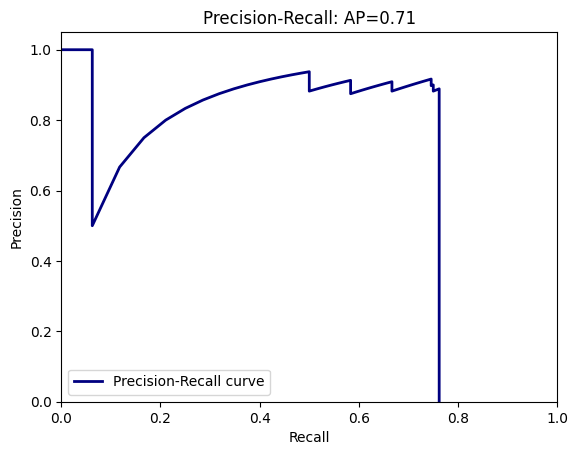

IoU threshold set to: 0.65
TP: 45.0
FP: 10.0
FN: 18.0
Avg. overlap for danger = 0.7860
Precision for danger = 0.8182
Recall for danger = 0.7143
AP for danger and IoU threshold 0.65 = 0.6630


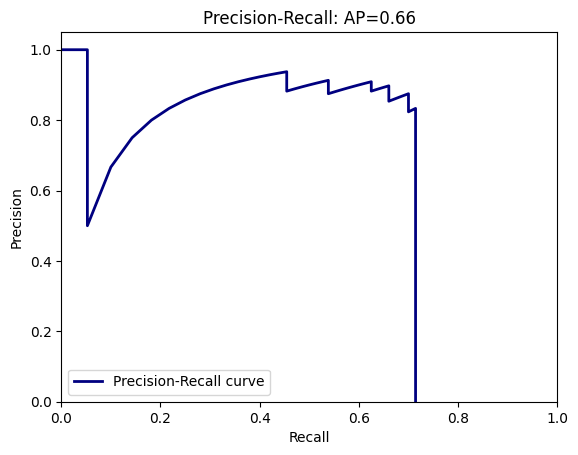

IoU threshold set to: 0.70
TP: 38.0
FP: 17.0
FN: 25.0
Avg. overlap for danger = 0.8080
Precision for danger = 0.6909
Recall for danger = 0.6032
AP for danger and IoU threshold 0.70 = 0.4962


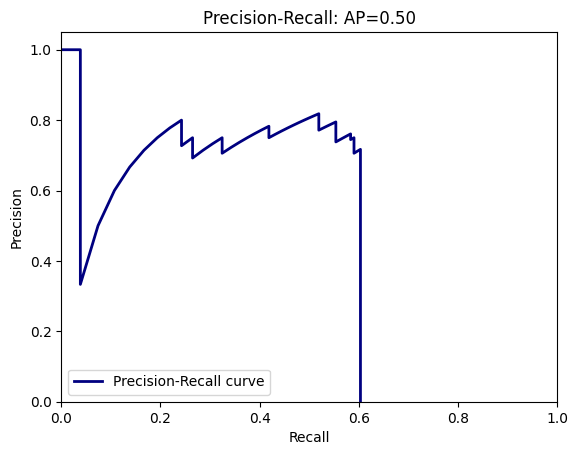

IoU threshold set to: 0.75
TP: 29.0
FP: 26.0
FN: 34.0
Avg. overlap for danger = 0.8347
Precision for danger = 0.5273
Recall for danger = 0.4603
AP for danger and IoU threshold 0.75 = 0.2809


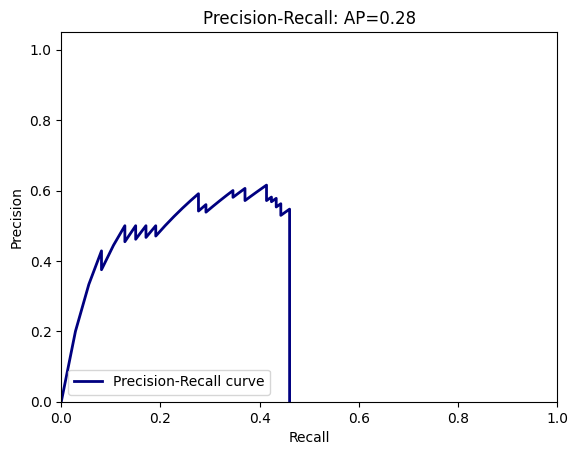

IoU threshold set to: 0.80
TP: 20.0
FP: 35.0
FN: 43.0
Avg. overlap for danger = 0.8589
Precision for danger = 0.3636
Recall for danger = 0.3175
AP for danger and IoU threshold 0.80 = 0.1496


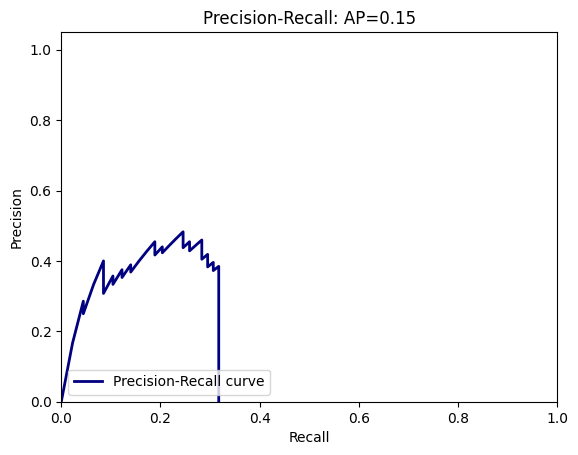

IoU threshold set to: 0.85
TP: 10.0
FP: 45.0
FN: 53.0
Avg. overlap for danger = 0.8937
Precision for danger = 0.1818
Recall for danger = 0.1587
AP for danger and IoU threshold 0.85 = 0.0477


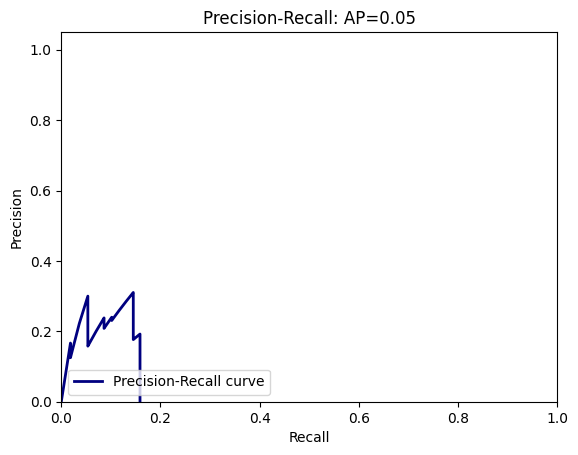

IoU threshold set to: 0.90
TP: 3.0
FP: 52.0
FN: 60.0
Avg. overlap for danger = 0.9324
Precision for danger = 0.0545
Recall for danger = 0.0476
AP for danger and IoU threshold 0.90 = 0.0040


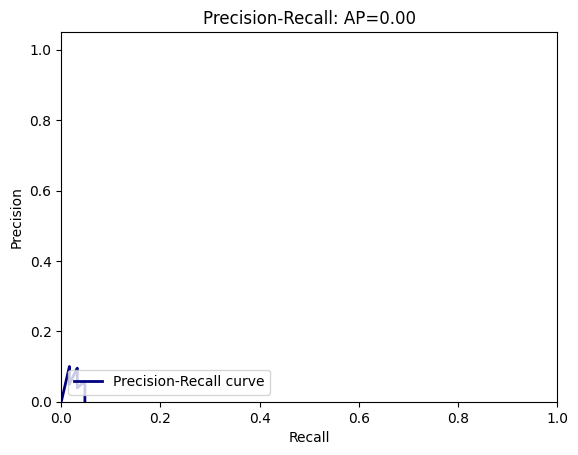

IoU threshold set to: 0.95
TP: 0.0
FP: 55.0
FN: 63.0
Avg. overlap for danger = 0.0000
Precision for danger = 0.0000
Recall for danger = 0.0000
AP for danger and IoU threshold 0.95 = 0.0000


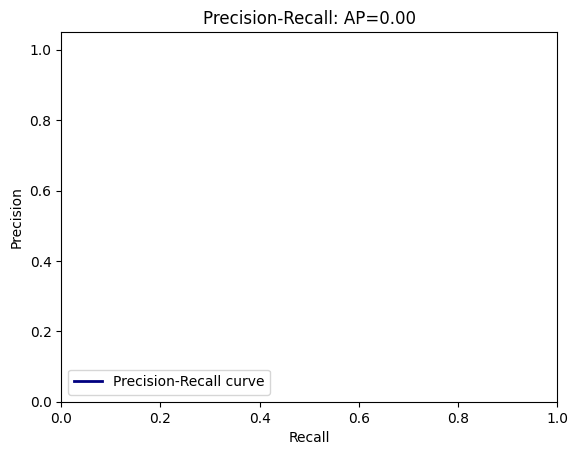

Mean AP for danger = 0.3959
Mean AP = 0.3626
~~~~~~~~
Results:
0.371
0.321
0.396
0.363


0.3625606153138568

In [43]:
compute_mean_average_precision_COCO2016(detections)